In [2]:
![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `[Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)'


In [0]:
!python3 -c 'import tensorflow as tf; print(tf.__version__)'

1.13.0-rc1


In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0] #28*28
w = h = int(np.sqrt(input_dim))

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [0]:
from tensorflow.contrib.slim import fully_connected as fc

class Autoencoder(object):
  def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.n_z = n_z
    
    tf.reset_default_graph()
    self.build()
    
    self.sess = tf.InteractiveSession()
    self.sess.run(tf.global_variables_initializer())
    
  # build the network and the loss function
  def build(self):
    self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])
    
    # Encoder (f)
    # x -> z
    
    f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
    f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
    f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
    self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)
    
    # Decoder (g)
    # z -> x'
    g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
    g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
    g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
    self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)
    
    # Loss: reconstruction loss
    # Minimize the cross-entropy loss
    # H(x, x_{hat}) = -\Sigma (x \times \log(x_{hat}) + (1 - x) \times \log(1 - x_{\hat}))
    epsilon = 1e-10
    recon_loss = tf.reduce_sum(
        self.x * tf.log(self.x_hat + epsilon) + (1 - self.x) * tf.log(1 - self.x_hat + epsilon),
        axis=1)
    self.recon_loss = -tf.reduce_mean(recon_loss)
    self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate)\
      .minimize(self.recon_loss)
    
    self.losses = {
        'recon_loss': self.recon_loss,
    }
    return
    
    
  def run_single_step(self, x):
    _, losses = self.sess.run(
        [self.train_op, self.losses],
        feed_dict={self.x: x}
    )
    return losses
  
  # x -> x_hat
  def reconstructor(self, x):
    x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
    return x_hat
  
  # x -> z
  def transformer(self, x):
    z = self.sess.run(self.z, feed_dict={self.x: x})
    return z

In [0]:
def trainer(model_object, learning_rate=1e-4, batch_size=64,num_epoch=100,
           n_z=16, log_step=5):
  model = model_object(learning_rate=learning_rate, batch_size=batch_size,n_z=n_z)
  for epoch in range(num_epoch):
    start_time = time.time()
    for iter in range(num_sample // batch_size):
      # get a batch
      batch = mnist.train.next_batch(batch_size)
      # execute the forward and backward path
      # report computed losses
      images, labels = batch
      losses = model.run_single_step(images)
    end_time = time.time()
    if epoch % log_step == 0:
      log_str = '[Epoch: {}] '.format(epoch)
      for k, v in losses.items():
        log_str += '{}: {:.3f}'.format(k, v)
      log_str += '({:.3f}sec/epoch)'.format(end_time - start_time)
      print(log_str)
  print('Done')
  return model

In [0]:
model = trainer(Autoencoder,num_epoch=10)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch: 0] recon_loss: 159.097(7.212sec/epoch)
[Epoch: 5] recon_loss: 101.036(7.320sec/epoch)
Done


In [0]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
  # test the trained model: reconstruction
  batch = mnist.test.next_batch(batch_size)
  x_recon = model.reconstructor(batch[0]) # [batch_size, 784]
  
  n = int(np.sqrt(batch_size))
  I_recon = np.empty((h*n,2*w*n))
  
  for i in range(n):
    for j in range(n):
      x = np.concatenate(
      (x_recon[i*n+j,:].reshape(h,w), batch[0][i*n+j,:].reshape(h,w)),axis=1
      )
      I_recon[i*h:(i+1)*h,j*2*w:(j+1)*2*w] = x
  plt.figure(figsize=(10,20))
  plt.imshow(I_recon,cmap='gray') 

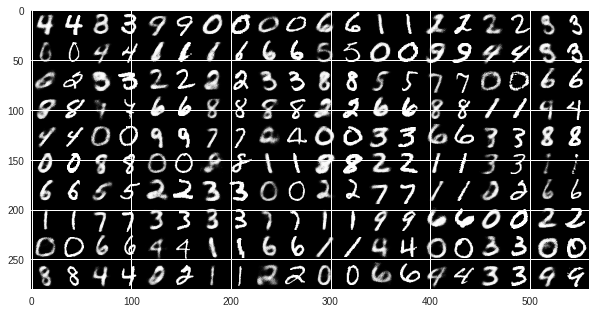

In [0]:
test_reconstruction(model,mnist)

In [0]:
# Train a model with 2d latent space
model_2d = trainer(Autoencoder, n_z=2, num_epoch=5)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch: 0] recon_loss: 190.715(9.558sec/epoch)
Done


In [0]:
def test_transformation(model_2d, mnist, batch_size=100):
  assert model_2d.n_z == 2
  batch = mnist.test.next_batch(batch_size)
  z = model_2d.transformer(batch[0]) # [batch_size, 2]
  plt.figure(figsize=(10,10))
  plt.scatter(z[:,0],z[:,1],c=np.argmax(batch[1],1), s=20)
  plt.colorbar()
  plt.grid()

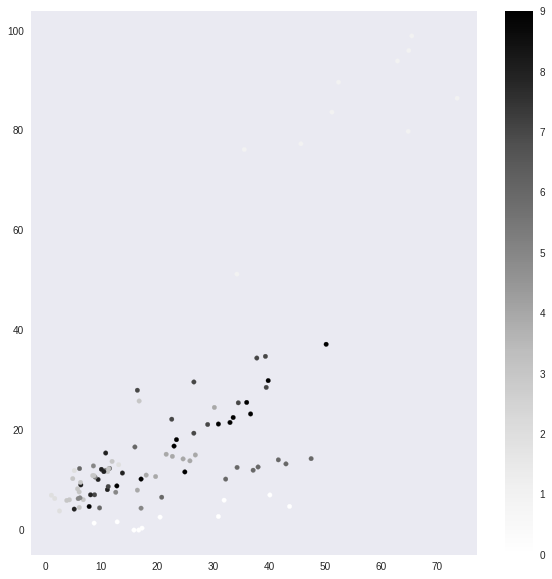

In [0]:
test_transformation(model_2d,mnist)

##VAE Demo

In [0]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [0]:
# Train a model
model = trainer(VariantionalAutoencoder)

In [0]:
test_reconstruction(model, mnist)

In [0]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [0]:
# Train a model with 2d latent space
model_2d = trainer(VariantionalAutoencoder, n_z=2)

In [0]:
test_transformation(model_2d, mnist)

In [0]:
the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")